# CMEMS SL-TAC along-track products
Satellite altimetry measurements in CMEMS are also available in an along-track format, mainly for assimilation into models. These are called Level 3 (L3) and provide intercalibrated SSH measurements, for all missions avaialable.

In [55]:
!ls ./data/*l3*

./data/dt_global_s3a_phy_l3_20190101_20190515.nc
./data/dt_global_s3a_phy_l3_20190102_20190515.nc
./data/dt_global_s3b_phy_l3_20190101_20190515.nc
./data/dt_global_s3b_phy_l3_20190102_20190515.nc


In [56]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

In [57]:
# file structure discovery
# everything is indexed by time
nc = xr.open_dataset('./data/dt_global_s3a_phy_l3_20190101_20190515.nc')
print(nc)

<xarray.Dataset>
Dimensions:         (time: 46745)
Coordinates:
  * time            (time) datetime64[ns] 2019-01-01T00:10:58.661460224 ... 2019-01-01T23:32:47.235198976
    longitude       (time) float64 ...
    latitude        (time) float64 ...
Data variables:
    cycle           (time) int16 ...
    track           (time) int16 ...
    dac             (time) float32 ...
    lwe             (time) float32 ...
    mdt             (time) float32 ...
    ocean_tide      (time) float64 ...
    sla_filtered    (time) float32 ...
    sla_unfiltered  (time) float32 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                 

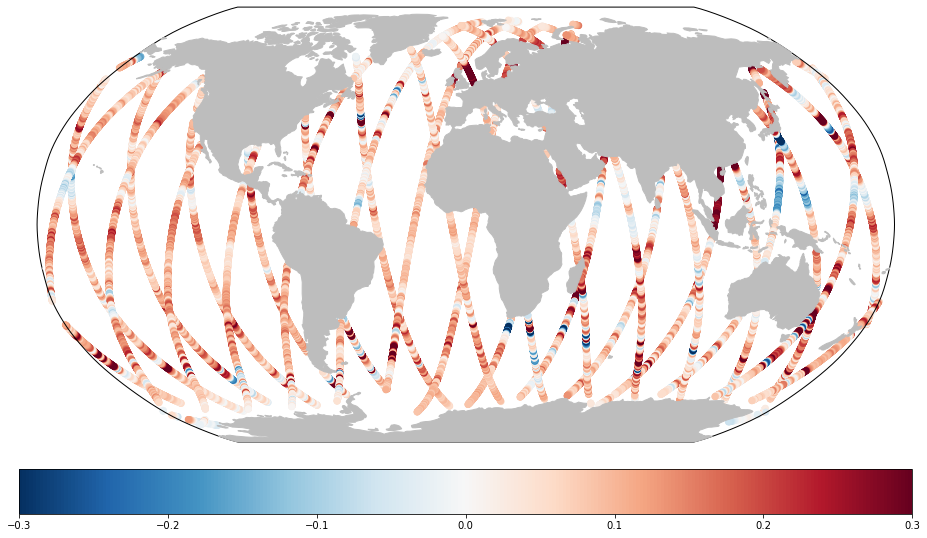

In [58]:
# plotting the content of a file
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.LAND, color='#bdbdbd',zorder=10)
mappable = ax.scatter(nc['longitude'],
                     nc['latitude'],
                     c=nc['sla_filtered'],
                     cmap='RdBu_r',
                     vmin=-0.3,
                     vmax=0.3,
                     transform=ccrs.PlateCarree())
fig.colorbar(mappable, ax=ax, orientation='horizontal', pad=.05)

[717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734
 735 736 737 738 739 740 741 742 743 744]


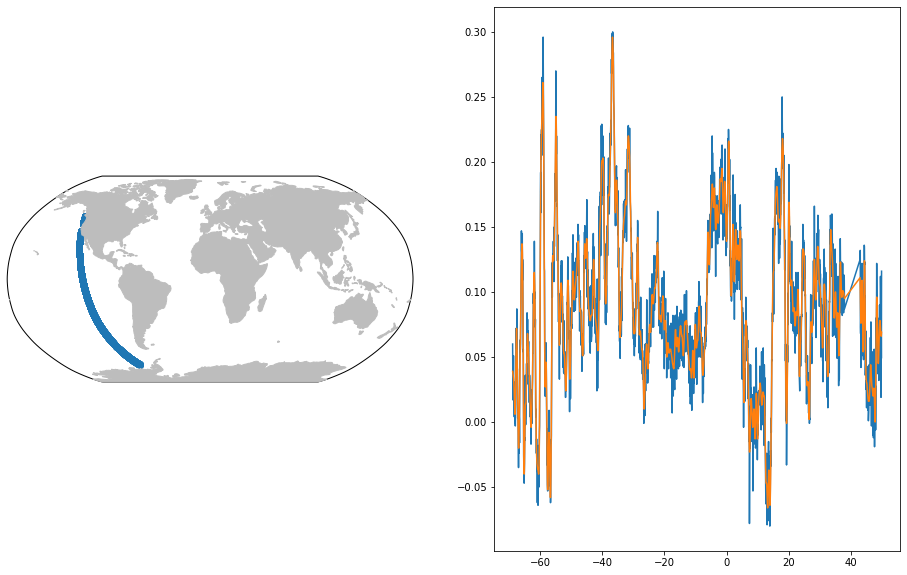

In [61]:
# selecting data based on track number
# list tracks in file
print(np.unique(nc['track'].data))

# track number to be selected
t=723
subsettrack = nc.sel(time=(nc.track==t))

# plot the track on the map, and along-track values
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(121, projection=ccrs.Robinson())
ax2 = fig.add_subplot(122)
ax1.add_feature(cfeature.LAND, color='#bdbdbd',zorder=10)
ax1.set_global()
ax1.scatter(subsettrack['longitude'], 
            subsettrack['latitude'],
           transform=ccrs.PlateCarree())

ax2.plot(subsettrack['latitude'], subsettrack['sla_unfiltered'])
ax2.plot(subsettrack['latitude'], subsettrack['sla_filtered'])
# try the same thing by selecting two tracks at a time

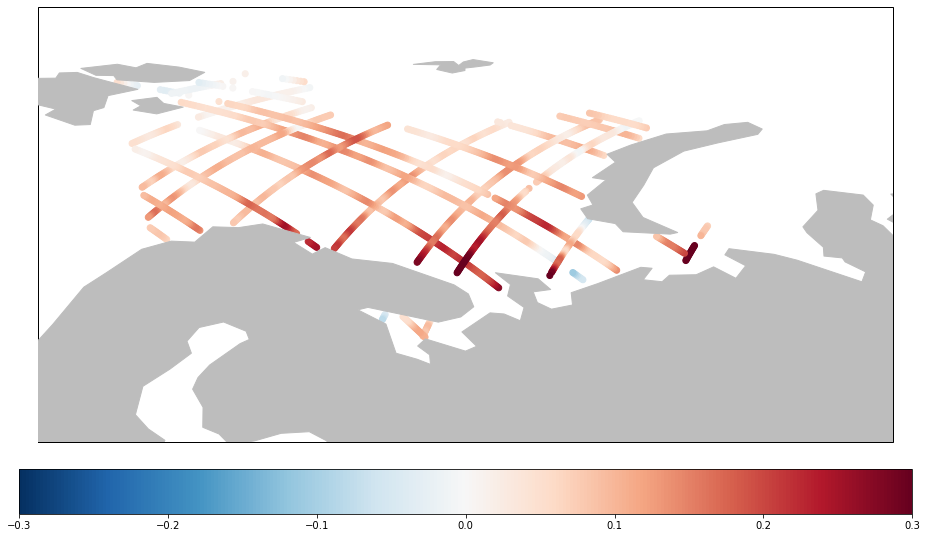

In [62]:
# selecting data based on and area of interest
# let's say we want only data in the Barents Sea, 
# roughly defined by a lat/lon box
lat_min, lat_max = 65., 80.
lon_min, lon_max = 20., 60.

# create a figure
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_extent([lon_min-5, lon_max+5,lat_min-5, lat_max+5], crs= ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#bdbdbd',zorder=10)

# list all l3 files available
l_files = sorted(glob('./data/*l3*.nc'))

# iterate over l3 files
for f in l_files:
    
    # open file and select data
    nc = xr.load_dataset(f)
    subsetarea = nc.sel(time=(nc.longitude > lon_min) & (nc.longitude < lon_max) & (nc.latitude > lat_min) & (nc.latitude < lat_max))

    # show the data on the figure
    ax.scatter(subsetarea['longitude'], 
            subsetarea['latitude'],
           c=subsetarea['sla_filtered'],
           transform=ccrs.PlateCarree(),
              cmap='RdBu_r',
              vmin=-0.3, vmax=0.3)

# add colorbar
fig.colorbar(mappable, ax=ax, orientation='horizontal', pad=.05)

## estimating currents
We can estimate along-trach SSH gradients, and therefore cross-track geostrophic currents, let's try to do that.

$ v = \frac{g}{f} * \frac{d (ssh)}{d x}$<br>

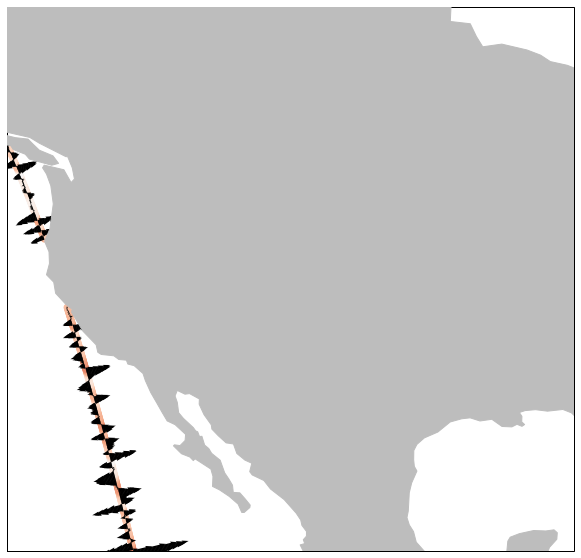

In [137]:
# compute distances from point to point
def haversine(lon1, lat1, lon2, lat2):
    R = 6372.8*1000.# Earth radius in kilometers
     
    # convert degrees to radians
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    
    # lat/lon steps 
    delta_lat = lat2 - lat1
    delta_lon = np.radians(lon2 - lon1)
    
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
 
    return R * c
 
# estimate distance to previous/next measurements along one track
distance_to_next = haversine(subsettrack['longitude'].data[0:-1],
                            subsettrack['latitude'].data[0:-1],
                            subsettrack['longitude'].data[1::1],
                            subsettrack['latitude'].data[1::1])


# compute Coriolis factor
g= 9.81
f0 = 2 * 7.2921*10**-5
g_over_f = g/(f0 * np.sin(np.radians(subsettrack['latitude'].data)))

# compute SLA gradients (very naively)
prev_sla = subsettrack['sla_filtered'][0:-1].data
next_sla = subsettrack['sla_filtered'][1::1].data
grad_sla = (next_sla - prev_sla) / (2*distance_to_next)
ugeo = grad_sla * g_over_f[0:-1]

# compute U/V components
# compute cos(a) and sin(a) 
# where a is the angle between the track and the meridians
adj = haversine(np.zeros(len(subsettrack['latitude'].data[0:-1])),
               subsettrack['latitude'].data[0:-1],
               np.zeros(len(subsettrack['latitude'].data[0:-1])),
               subsettrack['latitude'].data[1::1])

opp = haversine(subsettrack['longitude'].data[0:-1],
                np.zeros(len(subsettrack['longitude'].data[0:-1])),
               subsettrack['longitude'].data[1::1],
               np.zeros(len(subsettrack['longitude'].data[1::1])))

cos_a = adj/distance_to_next
sin_a = opp/distance_to_next

# warning, I'm unsure about sign here
# zonal component = R*cos(a)
U = ugeo*cos_a
# meridional component 
V = ugeo*sin_a

# extent of the track
min_lon = subsettrack['longitude'].min()
max_lon = subsettrack['longitude'].max()



# show the results
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([min_lon,max_lon,20.,60.], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#bdbdbd',zorder=10)
ax.scatter(subsettrack['longitude'], 
            subsettrack['latitude'],
           c=subsettrack['sla_filtered'],
           cmap='RdBu_r',
           vmin=-0.3, vmax=0.3,
           transform=ccrs.PlateCarree())
ax.quiver(subsettrack['longitude'],
         subsettrack['latitude'],
         U,V,
         scale=3)
plt.show()